In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Stateful Nodes

In some cases, we would like our node to be stateful.
If you are not sure whether you should make your node stateful, you probably dont.

But, you can, here is how:

In [ ]:
# you define a function object that has __call__ method
class StatefulSum():

    def __init__(self):
        self.history = []
    def __call__(self,item):
        self.history.append(item)
        return sum(self.history)
    def __str__(self):
        return f'StatefulSum'

    # And you have to implement the following 3 methods
    # reset the state
    def reset(self):
        self.history = []

    # dump the state as a json serializable object
    def dump_state(self):
        return self.history

    # load the state from a json serializable object
    def load_state(self,state_object):
        self.history = state_object


In [ ]:
s = StatefulSum()
s(1)
s(2)
s(3)
s.dump_state()

[1, 2, 3]

In [ ]:
from ladle.diagrams import V,E,Define
from ladle.std import Condition
from pydantic import BaseModel, ConfigDict


In [ ]:
class TimerState(BaseModel):
    model_config = ConfigDict(extra='allow')
    timer: int = 0

    def set_timer(self,val):
        self.timer = val

    def tick(self):
        self.timer = self.timer -1 
        return self.timer

    @classmethod
    def is_time_up(cls,val):
        return val <= 0

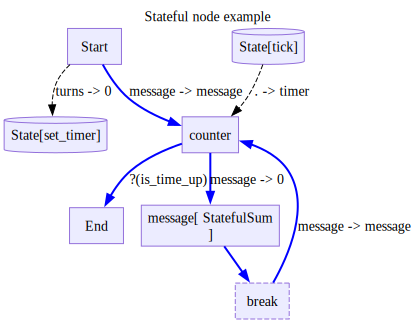

In [ ]:
with Define('Stateful node example',type='decision',state=TimerState) as D:
    V('Start',outputs=[
        'state/set_timer(0=turns)',
        'counter(message=message)'
    ])

    V('counter',
        inputs=['state/tick(timer)'],
        outputs=[
            ('End',Condition(TimerState.is_time_up,'0=timer','is_time_up')),
            'message(0=message)'
        ]
        )

    V('message',StatefulSum(),outputs=['break']),
    V('break',is_break=True,outputs=['counter(message=message)'])



In [ ]:
inputs = [
    {'message':1,'turns':4},
    {'message':2},
    {'message':3},
    {'message':4},
]
d=D()

while True:
    inp = inputs.pop(0)
    for trace in d.run(inp):
        trace.pprint(skip_passthrough=True)
    
    if d.finished:
        break

inputs

Node message:
{'input': {0: 1}, 'output': 1}
Node message:
{'input': {0: 2}, 'output': 3}
Node message:
{'input': {0: 3}, 'output': 6}


[]

We can see when dumping the diagram, that the state of the message node is also saved:

In [ ]:
d.dump_state()

{'state': {'timer': 0},
 'output': {'message': 4, 'timer': 0},
 'finished': True,
 'next_node': None,
 'run_uid': '5616513f-8a5b-45d0-939f-bafcfe67e475',
 'node_state': {'message': [1, 2, 3]}}